In [17]:
import pandas as pd

df1=pd.read_csv("Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE1_1_PeptideGroups.txt", sep="\t")
df2=pd.read_csv("Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE1_2_PeptideGroups.txt", sep="\t")
OUTPUT_FILE=    "Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE1_merged.tsv"

INCUBATION_TIME_SECONDS=3600 # 1h=3600s
df1.head()

,Checked,Confidence,Annotated Sequence,Modifications,# Protein Groups,# Proteins,# PSMs,Master Protein Accessions,Positions in Master Proteins,Modifications in Master Proteins,# Missed Cleavages,Theo. MH+ [Da],Abundance Ratio: (AC124_20uM) / (DMSO),Abundance Ratio: (AC124_50uM) / (DMSO),Abundance Ratio: (AC24_20uM) / (DMSO),Abundance Ratio: (AC24_50uM) / (DMSO),Abundance Ratio: (CL112_20uM) / (DMSO),Abundance Ratio: (CL112_50uM) / (DMSO),Abundance Ratio: (CL113_20uM) / (DMSO),Abundance Ratio: (CL113_50uM) / (DMSO),Abundance Ratio: (CL128_20uM) / (DMSO),Abundance Ratio: (CL128_50uM) / (DMSO),Abundance Ratio: (CL63_20uM) / (DMSO),Abundance Ratio: (CL63_50uM) / (DMSO),Abundance Ratio: (CL94_20uM) / (DMSO),Abundance Ratio: (CL94_50uM) / (DMSO),Abundance Ratio: (CL99_20uM) / (DMSO),Abundance Ratio: (CL99_50uM) / (DMSO),Abundances (Grouped): AC124_20uM,Abundances (Grouped): AC124_50uM,Abundances (Grouped): AC24_20uM,Abundances (Grouped): AC24_50uM,Abundances (Grouped): CL112_20uM,Abundances (Grouped): CL112_50uM,Abundances (Grouped): CL113_20uM,Abundances (Grouped): CL113_50uM,Abundances (Grouped): CL128_20uM,Abundances (Grouped): CL128_50uM,Abundances (Grouped): CL63_20uM,Abundances (Grouped): CL63_50uM,Abundances (Grouped): CL94_20uM,Abundances (Grouped): CL94_50uM,Abundances (Grouped): CL99_20uM,Abundances (Grouped): CL99_50uM,Abundances (Grouped): DMSO,Abundances (Grouped) CV [%]: AC124_20uM,Abundances (Grouped) CV [%]: AC124_50uM,Abundances (Grouped) CV [%]: AC24_20uM,Abundances (Grouped) CV [%]: AC24_50uM,Abundances (Grouped) CV [%]: CL112_20uM,Abundances (Grouped) CV [%]: CL112_50uM,Abundances (Grouped) CV [%]: CL113_20uM,Abundances (Grouped) CV [%]: CL113_50uM,Abundances (Grouped) CV [%]: CL128_20uM,Abundances (Grouped) CV [%]: CL128_50uM,Abundances (Grouped) CV [%]: CL63_20uM,Abundances (Grouped) CV [%]: CL63_50uM,Abundances (Grouped) CV [%]: CL94_20uM,Abundances (Grouped) CV [%]: CL94_50uM,Abundances (Grouped) CV [%]: CL99_20uM,Abundances (Grouped) CV [%]: CL99_50uM,Abundances (Grouped) CV [%]: DMSO,"Abundance: F1: 134N, Sample, n/a, AC124_20uM, n/a","Abundance: F1: 134C, Sample, n/a, AC124_50uM, n/a","Abundance: F1: 133N, Sample, n/a, AC24_20uM, n/a","Abundance: F1: 133C, Sample, n/a, AC24_50uM, n/a","Abundance: F1: 130N, Sample, n/a, CL112_20uM, n/a","Abundance: F1: 130C, Sample, n/a, CL112_50uM, n/a","Abundance: F1: 131N, Sample, n/a, CL113_20uM, n/a","Abundance: F1: 131C, Sample, n/a, CL113_50uM, n/a","Abundance: F1: 132N, Sample, n/a, CL128_20uM, n/a","Abundance: F1: 132C, Sample, n/a, CL128_50uM, n/a","Abundance: F1: 127N, Sample, n/a, CL63_20uM, n/a","Abundance: F1: 127C, Sample, n/a, CL63_50uM, n/a","Abundance: F1: 128N, Sample, n/a, CL94_20uM, n/a","Abundance: F1: 128C, Sample, n/a, CL94_50uM, n/a","Abundance: F1: 129N, Sample, n/a, CL99_20uM, n/a","Abundance: F1: 129C, Sample, n/a, CL99_50uM, n/a","Abundance: F1: 126, Sample, n/a, DMSO, n/a","Abundance: F1: 135N, Sample, n/a, DMSO, n/a",Quan Info,"Found in Sample: F1: 134N, Sample, n/a, AC124_20uM, n/a","Found in Sample: F1: 134C, Sample, n/a, AC124_50uM, n/a","Found in Sample: F1: 133N, Sample, n/a, AC24_20uM, n/a","Found in Sample: F1: 133C, Sample, n/a, AC24_50uM, n/a","Found in Sample: F1: 130N, Sample, n/a, CL112_20uM, n/a","Found in Sample: F1: 130C, Sample, n/a, CL112_50uM, n/a","Found in Sample: F1: 131N, Sample, n/a, CL113_20uM, n/a","Found in Sample: F1: 131C, Sample, n/a, CL113_50uM, n/a","Found in Sample: F1: 132N, Sample, n/a, CL128_20uM, n/a","Found in Sample: F1: 132C, Sample, n/a, CL128_50uM, n/a","Found in Sample: F1: 127N, Sample, n/a, CL63_20uM, n/a","Found in Sample: F1: 127C, Sample, n/a, CL63_50uM, n/a","Found in Sample: F1: 128N, Sample, n/a, CL94_20uM, n/a","Found in Sample: F1: 128C, Sample, n/a, CL94_50uM, n/a","Found in Sample: F1: 129N, Sample, n/a, CL99_20uM, n/a","Found in Sample: F1: 129C, Sample, n/a, CL99_50uM, n/a","Found in Sample: F1: 126, Sample, n/a, DMSO, n/a","Found in Sample: F1: 135N, Sample, n/a, DMSO, n/a",PSM Confidenc

In [18]:
import re
from collections import defaultdict
import pandas as pd # For example usage

def parse_annotated_sequence(annot_seq_str: str) -> str:
    """
    Extracts the core peptide sequence from the 'Annotated Sequence' string.
    Example: "[K].VLQCHKPVHAEYLEK.[L]" -> "VLQCHKPVHAEYLEK"
    Handles formats like [K].PEPTIDE.[L], [RK].PEPTIDE.[L], or [-].PEPTIDE.[L]
    """
    parts = annot_seq_str.split('.')
    if len(parts) == 3:
        # This is a simple fallback; primary regex is preferred for consistency.
        # print(f"Warning: Using fallback peptide parsing for: {annot_seq_str}")
        return parts[1]
        
    raise ValueError(f"Cannot parse peptide from Annotated Sequence: {annot_seq_str}")

def parse_positions_in_master_proteins(pos_str: str) -> tuple[int, str]:
    """
    Extracts the start position and the full position string.
    Example: "A0A024RBG1 [129-143]" -> (129, "A0A024RBG1 [129-143]")
    """
    match = re.search(r"\[(\d+)-(\d+)\]", pos_str)
    if match:
        start_pos = int(match.group(1))
        # The full string is used for the 'peptide' key in the output dict
        return start_pos, pos_str
    raise ValueError(f"Cannot parse start position from: {pos_str}")

def process_row_updated(row: pd.Series) -> dict:
    peptide_sequence = parse_annotated_sequence(row['Annotated Sequence'])
    start_pos, peptide_key_val = parse_positions_in_master_proteins(row['Positions in Master Proteins'])
    
    modifications_str = str(row['Modifications'])
    parsed_mod_details = {}

    # CORRECTED LINE: Use re.split for more robust outer splitting
    # This splits by a semicolon followed by zero or more whitespace characters.
    individual_mods = re.split(r';?\s*\d+x', modifications_str) #match "; 1x"
    for mod_entry in individual_mods:
        mod_entry_stripped = mod_entry.strip()
        if not mod_entry_stripped:
            continue
            
        mod_match = re.match(r"([a-zA-Z0-9_\-+]+)\s*\[(.*?)\]", mod_entry_stripped)
        mod_type = mod_match.group(1)
        mod_details_str = mod_match.group(2).strip()

        if mod_type not in parsed_mod_details:
            parsed_mod_details[mod_type] = []
        
        current_mod_positions_for_this_entry = []

        if mod_details_str.upper() == "N-TERM":
            abs_pos = start_pos + (1 - 1)
            current_mod_positions_for_this_entry.append(abs_pos)
        else:
            # This inner split for details like [K6; K15] was already robust
            site_descriptors = re.split(r';\s*', mod_details_str)
            for site_desc in site_descriptors:
                site_desc_stripped = site_desc.strip()
                if not site_desc_stripped: continue

                site_match = re.match(r"([A-Z])?(\d+)", site_desc_stripped)
                if site_match:
                    peptide_index = int(site_match.group(2))
                    if not (0 < peptide_index <= len(peptide_sequence)):
                        # print(f"Warning: Peptide index {peptide_index} for mod '{mod_type}' on site '{site_desc_stripped}' is out of bounds for peptide '{peptide_sequence}' (length {len(peptide_sequence)}). Skipping this site.")
                        continue
                    abs_pos = start_pos + (peptide_index - 1)
                    current_mod_positions_for_this_entry.append(abs_pos)
        if current_mod_positions_for_this_entry:
            parsed_mod_details[mod_type].extend(current_mod_positions_for_this_entry)

    result_dict = {'peptide': peptide_key_val}
    for mod_type, positions in parsed_mod_details.items():
        result_dict[mod_type] = sorted(list(set(positions))) if positions else []

    if 'DBIA' not in result_dict:
        result_dict['DBIA'] = []
    if 'TMTpro' not in result_dict:
        result_dict['TMTpro'] = []
    
    print(result_dict)
    return result_dict



def parse_peptide_from_annotated_sequence(annot_seq_str: str) -> str:
    """
    Extracts the core peptide sequence from the 'Annotated Sequence' string.
    Expected format example: "[K].VLQCHKPVHAEYLEK.[L]"
    """
    match = re.match(r"\[[A-Z-]{1,2}\]\.([A-Z]+)\.\[[A-Z-]\]", annot_seq_str)
    if match:
        return match.group(1)
    else:
        parts = annot_seq_str.split('.')
        if len(parts) == 3:
            return parts[1]
    raise ValueError(f"Cannot parse peptide from 'Annotated Sequence': '{annot_seq_str}' using known patterns.")

def generate_formatted_peptide_identifier(annotated_sequence_str: str, modifications_str: str) -> str:
    if pd.isna(annotated_sequence_str) or not annotated_sequence_str:
        return ""
    
    try:
        peptide_sequence = parse_peptide_from_annotated_sequence(annotated_sequence_str)
    except ValueError as e:
        return f"ErrorParsingPeptide: {annotated_sequence_str}"

    if pd.isna(modifications_str) or not modifications_str:
        return peptide_sequence # Return raw peptide if no modifications string

    if not peptide_sequence:
        return ""

    parsed_mod_applications = [] 

    # --- MODIFIED PART: Using re.findall() for outer segmentation ---
    # This pattern defines what one full modification entry looks like.
    # It has no capturing groups here, so findall returns a list of strings (the full entries).
    single_full_entry_pattern = r"\d+x\s*[a-zA-Z0-9_+-]+\s*\[.*?\]"
    individual_mod_entries = re.findall(single_full_entry_pattern, modifications_str)
    # --- End of MODIFIED PART ---

    for entry_stripped in individual_mod_entries: # entry_stripped is now a full "Nx ModName [Details]"
        # This pattern is for deconstructing the already isolated entry.
        # It HAS capturing groups to get the base name and details.
        # Group 1: Nx prefix (e.g., "1x ")
        # Group 2: Base modification name (e.g., "TMTpro")
        # Group 3: Details in brackets (e.g., "N-Term", "C4", "K6; K15")
        deconstruct_pattern = r"(\d+x\s*)([a-zA-Z0-9_+-]+)\s*\[(.*?)\]"
        mod_entry_match = re.match(deconstruct_pattern, entry_stripped)

        if not mod_entry_match:
            # This should ideally not happen if findall worked correctly with a matching pattern.
            # print(f"Warning: Found entry '{entry_stripped}' could not be deconstructed.")
            continue
        
        mod_base_name = mod_entry_match.group(2)
        details_str = mod_entry_match.group(3).strip()
        mod_tag_to_insert = f"[{mod_base_name}]"

        if details_str.upper() == "N-TERM":
            if len(peptide_sequence) > 0:
                 parsed_mod_applications.append((0, mod_tag_to_insert))
        else:
            site_descriptors = re.split(r';\s*', details_str) # This splits "K6; K15"
            for site_desc in site_descriptors:
                site_desc_stripped = site_desc.strip()
                if not site_desc_stripped: continue

                site_match = re.match(r"([A-Z])?(\d+)", site_desc_stripped)
                if site_match:
                    specified_residue_char = site_match.group(1)
                    position_1_based = int(site_match.group(2))
                    peptide_0_based_idx = position_1_based - 1

                    if not (0 <= peptide_0_based_idx < len(peptide_sequence)):
                        # print(f"Warning: Position {position_1_based} ('{site_desc_stripped}') for mod '{mod_base_name}' is out of bounds for peptide '{peptide_sequence}'.")
                        continue
                    
                    if specified_residue_char:
                        actual_residue = peptide_sequence[peptide_0_based_idx]
                        if actual_residue.upper() != specified_residue_char.upper():
                            # print(f"Warning: Residue mismatch for '{site_desc_stripped}'. Mod '{mod_base_name}' for '{specified_residue_char}', found '{actual_residue}'. Mod placed anyway.")
                            pass 
                    
                    parsed_mod_applications.append((peptide_0_based_idx, mod_tag_to_insert))

    if not parsed_mod_applications:
        return peptide_sequence

    mods_at_peptide_index = defaultdict(list)
    for rel_idx, mod_tag in parsed_mod_applications:
        mods_at_peptide_index[rel_idx].append(mod_tag)

    insertions = []
    for rel_idx, tags_list in mods_at_peptide_index.items():
        if tags_list:
            tags_list.sort() 
            combined_tags_str = "".join(tags_list)
            insertions.append((rel_idx, combined_tags_str))

    insertions.sort(key=lambda x: x[0], reverse=True)

    seq_char_list = list(peptide_sequence)
    for rel_idx, combined_tags_str_to_insert in insertions:
        seq_char_list.insert(rel_idx + 1, combined_tags_str_to_insert)
        
    return "".join(seq_char_list)


In [19]:
# Apply the updated function to each row to create the new 'index' column
df1['dict'] = df1.apply(process_row_updated, axis=1)
print([index for index in df1["dict"]])

df1['Formatted_Peptide_ID'] = df1.apply(lambda row: generate_formatted_peptide_identifier(row['Annotated Sequence'], row['Modifications']),axis=1)
df1.set_index('Formatted_Peptide_ID', inplace=True)

# Apply the updated function to each row to create the new 'index' column
df2['dict'] = df2.apply(process_row_updated, axis=1)
print([index for index in df2["dict"]])

df2['Formatted_Peptide_ID'] = df2.apply(lambda row: generate_formatted_peptide_identifier(row['Annotated Sequence'], row['Modifications']),axis=1)
df2.set_index('Formatted_Peptide_ID', inplace=True)

df2.to_csv("temp.tsv", sep="\t")

{'peptide': 'A0A024RBG1 [129-143]', 'TMTpro': [129, 134, 143], 'DBIA': [132]}
{'peptide': 'A0A096LP55 [79-85]', 'TMTpro': [79, 85], 'DBIA': [81]}
{'peptide': 'A0A1B0GUS4 [83-100]', 'TMTpro': [83, 96, 100], 'DBIA': [86]}
{'peptide': 'A0A1W2PPD8 [390-395]', 'TMTpro': [390, 395], 'DBIA': [391]}
{'peptide': 'A0A3B3IRV3 [9-18]', 'TMTpro': [9, 18], 'DBIA': [14]}
{'peptide': 'A0A8I5KQE6 [129-155]', 'TMTpro': [129], 'DBIA': [148]}
{'peptide': 'A0A8I5KQE6 [156-166]', 'TMTpro': [156, 166], 'DBIA': [163]}
{'peptide': 'A0AV96 [141-152]', 'TMTpro': [141], 'DBIA': [145], 'Carbamidomethyl': [146, 151]}
{'peptide': 'A0AV96 [141-152]', 'TMTpro': [141], 'DBIA': [145, 146], 'Carbamidomethyl': [151]}
{'peptide': 'A0AV96 [265-276]', 'TMTpro': [265], 'DBIA': [273]}
{'peptide': 'A0AV96 [70-77]', 'TMTpro': [70, 77], 'DBIA': [71]}
{'peptide': 'A0AVF1 [226-231]', 'TMTpro': [226], 'DBIA': [227]}
{'peptide': 'A0AVT1 [176-182]', 'TMTpro': [176, 182], 'DBIA': [178]}
{'peptide': 'A0AVT1 [448-457]', 'TMTpro': [448, 4

In [21]:
import pandas as pd
import numpy as np # Used for np.nan in sample data creation


# 1. Rename columns
df1_renamed = df1.copy()
df1_renamed.columns = [f"{col}_rep1" for col in df1.columns]
df2_renamed = df2.copy()
df2_renamed.columns = [f"{col}_rep2" for col in df2.columns]

# 2. Merge DataFrames
merged_df = pd.merge(df1_renamed, df2_renamed,
                     left_index=True,
                     right_index=True,
                     how='outer')

# 3. Add 'In_Both_Reps' column
df1_original_indices = set(df1.index)
df2_original_indices = set(df2.index)
common_indices = df1_original_indices.intersection(df2_original_indices)
merged_df['In_Both_Reps'] = merged_df.index.isin(common_indices)

# 4. Alphabetically reorder ALL columns (as done in the previous step)
all_column_names = merged_df.columns.tolist()
sorted_all_column_names = sorted(all_column_names)
merged_df = merged_df[sorted_all_column_names]

# 5. Move 'In_Both_Reps' to the first position
column_to_move_first = 'In_Both_Reps'
if column_to_move_first in merged_df.columns:
    # Get a list of current column names
    current_columns = merged_df.columns.tolist()
    # Remove the column from its current position
    current_columns.remove(column_to_move_first)
    # Create the new desired order: the specific column first, then the rest
    new_column_order = [column_to_move_first] + current_columns
    # Reindex the DataFrame with this new column order
    merged_df = merged_df[new_column_order]

    print(f"\n--- Merged DataFrame AFTER moving '{column_to_move_first}' to the first position ---")
else:
    print(f"\nWarning: Column '{column_to_move_first}' not found in merged_df. Skipping reordering.")


merged_df.to_csv(OUTPUT_FILE, sep="\t")


--- Merged DataFrame AFTER moving 'In_Both_Reps' to the first position ---


In [22]:
#fitting
compound_conc_dict={} #{cmpdA:[conc1_in_M, conc2_in_M]}
treatments=set()
treatment_column_names = []

# Extract compound name and conc.
for column_name in merged_df.columns.to_list():
    matchObj = re.match(r"Abundance Ratio: \((.*)\) / \(DMSO\)_rep\d+", column_name)
    if matchObj:
        treatments.add(matchObj.group(1))
        treatment_column_names.append(matchObj.group())
treatments = sorted(treatments)

for treatment in treatments:
    cmpd, conc = treatment.split("_")[0], treatment.split("_")[1]
    if conc.endswith("uM"):
        conc_M = float(re.sub(r"[a-zA-Z ]","",conc)) * 1e-6
    if conc.endswith("nM"):
        conc_M = float(re.sub(r"[a-zA-Z ]","",conc)) * 1e-9
    if conc.endswith("mM"):
        conc_M = float(re.sub(r"[a-zA-Z]","",conc)) * 1e-3
    if cmpd not in compound_conc_dict:
        compound_conc_dict[cmpd] = []
    compound_conc_dict[cmpd].append(conc_M)

print(treatment_column_names) # ['Abundance Ratio: (CL123_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL123_20uM) / (DMSO)_rep2', 'Abundance Ratio: (CL123_50uM) / (DMSO)_rep1', 'Abundance Ratio: (CL123_50uM) / (DMSO)_rep2',...]
print(compound_conc_dict) # {'CL123': [1.9999999999999998e-05, 4.9999999999999996e-05], ...}





['Abundance Ratio: (AC124_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep2', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep2', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep2', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep2', 'Abundance Ratio: (CL112_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL112_20uM) / (DMSO)_rep2', 'Abundance Ratio: (CL112_50uM) / (DMSO)_rep1', 'Abundance Ratio: (CL112_50uM) / (DMSO)_rep2', 'Abundance Ratio: (CL113_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL113_20uM) / (DMSO)_rep2', 'Abundance Ratio: (CL113_50uM) / (DMSO)_rep1', 'Abundance Ratio: (CL113_50uM) / (DMSO)_rep2', 'Abundance Ratio: (CL128_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL128_20uM) / (DMSO)_rep2', 'Abundance Ratio: (CL128_50uM) / (DMSO)_rep1', 'Abundance Ratio: (CL128_50uM) / (DMSO)_rep2', 'Abundance Ratio: (CL63_20uM) / (DMSO)_rep1', 'Abundance Ratio:

In [36]:
k_obs_results_list = []

# Pre-process treatment columns for easier lookup
# Map: (compound, conc_M) -> [list_of_column_names_for_replicates]
treatment_cols_map = defaultdict(lambda: defaultdict(list))
for col_name in treatment_column_names:
    matchObj = re.match(r"Abundance Ratio: \((.*)\) / \(DMSO\)_rep\d+", col_name)
    if matchObj:
        treatment_tag = matchObj.group(1)  # e.g., "CmpdA_10uM"
        parts = treatment_tag.split("_")
        if len(parts) >= 2:
            cmpd = parts[0]
            conc_str_part = parts[1]
            
            conc_M = np.nan
            conc_value_str = re.sub(r"[a-zA-Z ]", "", conc_str_part)
            if pd.notna(conc_value_str) and conc_value_str != '':
                conc_float = float(conc_value_str)
                if conc_str_part.endswith("uM"): conc_M = conc_float * 1e-6
                elif conc_str_part.endswith("nM"): conc_M = conc_float * 1e-9
                elif conc_str_part.endswith("mM"): conc_M = conc_float * 1e-3
            
            if pd.notna(conc_M):
                conc_M = round(conc_M, 12)
                treatment_cols_map[cmpd][conc_M].append(col_name)

print(treatment_cols_map)

# Now, iterate using the structured map
for peptide_idx, peptide_data_row in merged_df.iterrows():
    for compound_name, conc_sub_map in treatment_cols_map.items():
        for conc_M_value, list_of_rep_cols in conc_sub_map.items():
            dbia_ratios_for_reps = []
            for col in list_of_rep_cols:
                ratio = peptide_data_row.get(col) # Get ratio for current peptide and column
                if pd.notna(ratio):
                    dbia_ratios_for_reps.append(ratio)
            
            if not dbia_ratios_for_reps: # No data for this peptide under this compound/concentration
                continue

            current_k_obs_values = []
            current_occupancies = []
            
            for ratio in dbia_ratios_for_reps:
                # Occupancy = 1 - DBIA_ratio.
                # For k_obs = -ln(DBIA_ratio)/time, DBIA_ratio should be > 0 and <= 1.
                # If DBIA_ratio = 1, occupancy = 0, k_obs = 0.
                # If DBIA_ratio -> 0, occupancy -> 1, k_obs -> infinity.
                # We need to handle these edge cases.
                
                if 0 < ratio < 1: # Strict inequality for log, typical case
                    occupancy = 1 - ratio
                    current_occupancies.append(occupancy)
                    # From DBIA_ratio = exp(-k_obs * time) => k_obs = -ln(DBIA_ratio) / time
                    k_obs = -np.log(ratio) / INCUBATION_TIME_SECONDS
                    current_k_obs_values.append(k_obs)
                elif ratio >= 1: # DBIA_ratio is 1 (or very close)
                    current_occupancies.append(0.0)
                    current_k_obs_values.append(0.0) # k_obs is 0 if no change from DMSO
                # elif np.isclose(ratio, 0.0): # DBIA_ratio is 0 (or very close) -> occupancy is 1
                    # current_occupancies.append(1.0)
                    # current_k_obs_values.append(np.inf) # k_obs tends to infinity
                    # print(f"Warning: DBIA ratio near 0 for {peptide_idx}, {compound_name}, {conc_M_value}. k_obs is effectively infinite.")
                # else: DBIA ratio is < 0 or > 1 (problematic data)
                    # print(f"Warning: DBIA ratio {ratio} out of (0,1] range for {peptide_idx}, {compound_name}, {conc_M_value}. Cannot calculate k_obs reliably.")
                    pass # Skip calculation for this replicate
            
            if current_k_obs_values: # If any k_obs were successfully calculated
                k_obs_results_list.append({
                    'Peptide_ID': peptide_idx,
                    'Compound': compound_name,
                    'Concentration_M': conc_M_value,
                    'Mean_Occupancy': np.mean(current_occupancies) if current_occupancies else np.nan,
                    'k_obs_Mean': np.mean(current_k_obs_values),
                    'k_obs_Replicates': current_k_obs_values, # Store individual k_obs values
                    'DBIA_Ratios_Used': [r for r in dbia_ratios_for_reps if pd.notna(r) and r>0] # Store valid ratios used
                })

# Convert the list of results into a DataFrame for easier analysis/export
k_obs_summary_df = pd.DataFrame(k_obs_results_list)

print("\n--- Calculated k_obs Summary ---")
if not k_obs_summary_df.empty:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(k_obs_summary_df.head(30))
else:
    print("No k_obs values were calculated (check data, column names, and INCUBATION_TIME_SECONDS).")


 

defaultdict(<function <lambda> at 0x000001E656301820>, {'AC124': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (AC124_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep2'], 5e-05: ['Abundance Ratio: (AC124_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep2']}), 'AC24': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (AC24_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep2'], 5e-05: ['Abundance Ratio: (AC24_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep2']}), 'CL112': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (CL112_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL112_20uM) / (DMSO)_rep2'], 5e-05: ['Abundance Ratio: (CL112_50uM) / (DMSO)_rep1', 'Abundance Ratio: (CL112_50uM) / (DMSO)_rep2']}), 'CL113': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (CL113_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL113_20uM) / (DMSO)_rep2'], 5e-05: ['Abundance Ratio: (CL113_50uM) / (DMSO)_rep1', 'Abundance Rati

In [37]:
# For each (conc, k_obs), find the best model among linear/MichaelisMenton/Constant
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
# from collections import defaultdict # Not strictly needed in this revised snippet if k_obs_summary_df is structured

# --- Assume k_obs_summary_df is available ---
# This DataFrame should have columns like:
# 'Peptide_ID', 'Compound', 'Concentration_M', 'k_obs_Replicates' (a list of floats)


# --- 1. Model Definitions (as provided by you) ---
def linear_model(x, slope):
    return slope * x

def hyperbolic_model(x, vmax, km):
    return vmax * x / (km + x) # Added small epsilon for stability if km+x is zero

def constant_model(x, baseline):
    return baseline * np.ones_like(x)

# --- 2. AIC and BIC Computation Functions (as provided by you) ---
def compute_aic(n, rss, num_params, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + 2 * num_params

def compute_bic(n, rss, num_params, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + num_params * np.log(n)

# --- 3. Main Fitting and Model Selection Loop ---
fitting_results_list = []

# Ensure k_obs_summary_df is valid and has the necessary columns
if 'k_obs_summary_df' not in locals() or k_obs_summary_df.empty or \
   not all(col in k_obs_summary_df.columns for col in ['Peptide_ID', 'Compound', 'Concentration_M', 'k_obs_Replicates']):
    print("k_obs_summary_df is not defined, empty, or missing required columns ('Peptide_ID', 'Compound', 'Concentration_M', 'k_obs_Replicates').")
    model_comparison_results_df = pd.DataFrame()
else:
    grouped_data = k_obs_summary_df.groupby(['Peptide_ID', 'Compound'])

    for name, group_for_compound_peptide in grouped_data:
        peptide_id, compound_name = name
        
        x_for_fitting = [] # Will store all concentration values, repeated for replicates
        y_for_fitting = [] # Will store all individual k_obs replicate values
        
        # Iterate through each row in the group (each row is a unique concentration for the current peptide/compound)
        for _, conc_row in group_for_compound_peptide.iterrows():
            concentration = conc_row['Concentration_M']
            k_obs_reps = conc_row['k_obs_Replicates'] # This should be a list/array of k_obs values

            if isinstance(k_obs_reps, (list, np.ndarray, pd.Series)):
                for k_obs_val in k_obs_reps:
                    if pd.notna(concentration) and pd.notna(k_obs_val): # Ensure data is valid
                        x_for_fitting.append(concentration)
                        y_for_fitting.append(k_obs_val)
            # else:
                # Optional: print(f"Warning: k_obs_Replicates for {peptide_id}, {compound_name}, conc {concentration} is not a list: {k_obs_reps}")

        if not x_for_fitting: # No valid data points for this group
            # print(f"No valid data points for {peptide_id} - {compound_name}. Skipping fitting.")
            fitting_results_list.append({
                'Peptide_ID': peptide_id, 'Compound': compound_name, 'Num_Data_Points': 0,
                'Lin_Fit_Error': 'No data', 'Hyp_Fit_Error': 'No data', 'Const_Fit_Error': 'No data',
                'Best_Model_AIC': 'N/A', 'Best_Model_BIC': 'N/A'
            })
            continue

        x_data = np.array(x_for_fitting)
        y_data = np.array(y_for_fitting)
        
        # Sort data points by x_values (concentration) - primarily for visual consistency if plotting later
        sort_indices = np.argsort(x_data)
        x_data = x_data[sort_indices]
        y_data = y_data[sort_indices]
            
        n_points = len(y_data) # Total number of individual replicate data points
        
        result_row = {
            'Peptide_ID': peptide_id,
            'Compound': compound_name,
            'Num_Data_Points': n_points,
            'Concentrations_Fitted': list(x_data), # For reference
            'k_obs_Replicates_Fitted': list(y_data)  # For reference
        }
        
        # Initialize fit result fields
        for model_prefix in ['Lin', 'Hyp', 'Const']:
            result_row[f'{model_prefix}_RSS'] = np.nan
            result_row[f'{model_prefix}_AIC'] = np.nan
            result_row[f'{model_prefix}_BIC'] = np.nan
            result_row[f'{model_prefix}_Fit_Error'] = None # Store potential error messages
            if model_prefix == 'Lin' or model_prefix == 'Const':
                 result_row[f'{model_prefix}_Param_a'] = np.nan
            if model_prefix == 'Hyp':
                 result_row[f'{model_prefix}_Param_vmax'] = np.nan
                 result_row[f'{model_prefix}_Param_km'] = np.nan

        # --- Fit Linear Model ---
        num_params_lin = 1
        if n_points >= num_params_lin:
            try:
                popt_lin, _ = curve_fit(linear_model, x_data, y_data, maxfev=5000)
                y_pred_lin = linear_model(x_data, *popt_lin)
                rss_lin = np.sum((y_data - y_pred_lin) ** 2)
                result_row.update({'Lin_Param_a': popt_lin[0], 'Lin_RSS': rss_lin,
                                   'Lin_AIC': compute_aic(n_points, rss_lin, num_params_lin),
                                   'Lin_BIC': compute_bic(n_points, rss_lin, num_params_lin)})
            except RuntimeError: result_row['Lin_Fit_Error'] = 'RuntimeError'
            except ValueError as e: result_row['Lin_Fit_Error'] = f'ValueError: {str(e)[:50]}' # Keep error short
        else: result_row['Lin_Fit_Error'] = 'Not enough data'

        # --- Fit Hyperbolic Model ---
        num_params_hyp = 2
        if n_points >= num_params_hyp:
            try:
                p0_hyp = [np.max(y_data) if n_points > 0 else 1.0, np.median(x_data) if n_points > 0 else np.mean(x_data) if n_points > 0 else 1.0]
                # Ensure p0_hyp values are not nan/inf if y_data/x_data are empty or problematic
                if not all(np.isfinite(p0_hyp)): p0_hyp = None 

                popt_hyp, _ = curve_fit(hyperbolic_model, x_data, y_data, p0=p0_hyp,
                                        bounds=([0, 0], [np.inf, np.inf]), maxfev=10000)
                y_pred_hyp = hyperbolic_model(x_data, *popt_hyp)
                rss_hyp = np.sum((y_data - y_pred_hyp) ** 2)
                result_row.update({'Hyp_Param_vmax': popt_hyp[0], 'Hyp_Param_km': popt_hyp[1],
                                   'Hyp_RSS': rss_hyp, 'Hyp_AIC': compute_aic(n_points, rss_hyp, num_params_hyp),
                                   'Hyp_BIC': compute_bic(n_points, rss_hyp, num_params_hyp)})
            except RuntimeError: result_row['Hyp_Fit_Error'] = 'RuntimeError'
            except ValueError as e: result_row['Hyp_Fit_Error'] = f'ValueError: {str(e)[:50]}'
        else: result_row['Hyp_Fit_Error'] = 'Not enough data'

        # --- Fit Constant Model ---
        num_params_const = 1
        if n_points >= num_params_const:
            try:
                popt_const, _ = curve_fit(constant_model, x_data, y_data, maxfev=5000)
                y_pred_const = constant_model(x_data, *popt_const)
                rss_const = np.sum((y_data - y_pred_const) ** 2)
                result_row.update({'Const_Param_a': popt_const[0], 'Const_RSS': rss_const,
                                   'Const_AIC': compute_aic(n_points, rss_const, num_params_const),
                                   'Const_BIC': compute_bic(n_points, rss_const, num_params_const)})
            except RuntimeError: result_row['Const_Fit_Error'] = 'RuntimeError'
            except ValueError as e: result_row['Const_Fit_Error'] = f'ValueError: {str(e)[:50]}'
        else: result_row['Const_Fit_Error'] = 'Not enough data'
        
        # --- Determine Best Model ---
        aic_scores = {model: result_row.get(f'{model}_AIC', np.inf) for model in ['Lin', 'Hyp', 'Const']}
        valid_aic = {k: v for k, v in aic_scores.items() if pd.notna(v) and np.isfinite(v)}
        result_row['Best_Model_AIC'] = min(valid_aic, key=valid_aic.get) if valid_aic else 'Fit_Failed'

        bic_scores = {model: result_row.get(f'{model}_BIC', np.inf) for model in ['Lin', 'Hyp', 'Const']}
        valid_bic = {k: v for k, v in bic_scores.items() if pd.notna(v) and np.isfinite(v)}
        result_row['Best_Model_BIC'] = min(valid_bic, key=valid_bic.get) if valid_bic else 'Fit_Failed'
            
        fitting_results_list.append(result_row)

    model_comparison_results_df = pd.DataFrame(fitting_results_list)

# --- Display Results ---
print("\n--- Model Fitting and Comparison Results (using k_obs_Replicates) ---")
if not model_comparison_results_df.empty:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(model_comparison_results_df.head(20))
else:
    print("No fitting results to display.")

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



--- Model Fitting and Comparison Results (using k_obs_Replicates) ---
                                           Peptide_ID Compound  Num_Data_Points         Concentrations_Fitted                            k_obs_Replicates_Fitted       Lin_RSS     Lin_AIC     Lin_BIC Lin_Fit_Error    Lin_Param_a       Hyp_RSS     Hyp_AIC     Hyp_BIC Hyp_Fit_Error  Hyp_Param_vmax  Hyp_Param_km     Const_RSS   Const_AIC   Const_BIC Const_Fit_Error  Const_Param_a Best_Model_AIC Best_Model_BIC
0          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]    AC124                4  [2e-05, 2e-05, 5e-05, 5e-05]  [1.600808689906567e-05, 7.603110221147782e-06,...  3.427004e-10  -90.721835  -91.335541          None   2.551983e-01  2.670937e-10  -89.718864  -90.946275          None    1.689238e-05  1.857769e-05  2.414851e-10  -92.122030  -92.735736            None   1.094243e-05          Const          Const
1          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]     AC24                4  [2e-05, 2e-05, 5e-05, 5e-05]  

In [ ]:
# Final output based on AIC model choice
# If "Const", then have "Const_Param_a" in a column named "k_inact", and "<"+str(min(Concentrations_Fitted)/2) in a column named "K_I". 
# If "Lin", then have "Lin_Param_a" in a column named "k_inact/K_I". 
# If "Hyp", then have "Hyp_Param_vmax" in the same "k_inact" column, and "Hyp_Param_km" in the same "K_I" column, and also Hyp_Param_vmax/Hyp_Param_km in the same "k_inact/K_I" column

if 'model_comparison_results_df' not in locals() or model_comparison_results_df.empty:
    print("--- Creating Sample model_comparison_results_df for Parameter Interpretation ---")

def extract_final_kinetic_parameters(row):
    """
    Extracts k_inact, K_I, and k_inact/K_I based on the best model.
    """
    k_inact = np.nan
    K_I = np.nan  # This column will have mixed types (float or string)
    k_inact_over_K_I = np.nan

    best_model = row.get('Best_Model_AIC', 'Fit_Failed') # Default if 'Best_Model_AIC' is missing

    if best_model == 'Const':
        k_inact = row.get('Const_Param_a', np.nan)
        concentrations = row.get('Concentrations_Fitted', [])
        
        if concentrations and row.get('Num_Data_Points', 0) > 0:
            # Filter out potential NaNs before taking min, though 'Concentrations_Fitted' should be clean
            valid_concs = [c for c in concentrations if pd.notna(c)]
            if valid_concs:
                min_conc = min(valid_concs)
                k_i_val = min_conc / 2.0
                if k_i_val > 1e-12: # Avoid extremely small numbers leading to "<0.00e+00"
                    K_I = f"<{k_i_val:.2e}"
                elif k_i_val > 0 : # For very small positive values
                    K_I = f"<{k_i_val:.1e}" # Less precision for very small
                else: # min_conc was 0 or negative (should not happen for concentrations)
                    K_I = "<=0.0"
            else:
                K_I = "N/A (no valid concs)"
        else:
            K_I = "N/A (no data points)"
        # k_inact_over_K_I remains NaN

    elif best_model == 'Lin':
        k_inact_over_K_I = row.get('Lin_Param_a', np.nan)
        # k_inact and K_I remain NaN

    elif best_model == 'Hyp':
        vmax = row.get('Hyp_Param_vmax', np.nan)
        km = row.get('Hyp_Param_km', np.nan)
        
        k_inact = vmax
        K_I = km  # K_I will be a float here
        
        if pd.notna(vmax) and pd.notna(km):
            if km > 1e-18:  # Avoid division by zero or near-zero; 1e-18 is a small number
                k_inact_over_K_I = vmax / km
            elif np.isclose(km, 0) and np.isclose(vmax, 0):
                k_inact_over_K_I = np.nan # Or 0, interpretable as no activity
            elif np.isclose(km, 0) and not np.isclose(vmax, 0) and vmax > 0:
                k_inact_over_K_I = np.inf # Very efficient, indicates likely linear regime or extremely tight binding
            else: # km is effectively zero and vmax is negative/nan, or km negative (should not happen with bounds)
                k_inact_over_K_I = np.nan
        else: # vmax or km is NaN
            k_inact_over_K_I = np.nan
            
    # For 'Fit_Failed' or any other 'Best_Model_AIC' value, parameters remain np.nan

    return pd.Series([k_inact, K_I, k_inact_over_K_I], 
                     index=['k_inact', 'K_I', 'k_inact_over_K_I'])

# Apply this function to the model_comparison_results_df
if 'model_comparison_results_df' in locals() and not model_comparison_results_df.empty:
    # Ensure required columns exist for the function, even if they are all NaN from failed fits
    required_cols_for_extraction = [
        'Best_Model_AIC', 'Const_Param_a', 'Concentrations_Fitted', 'Num_Data_Points',
        'Lin_Param_a', 'Hyp_Param_vmax', 'Hyp_Param_km'
    ]
    for col in required_cols_for_extraction:
        if col not in model_comparison_results_df.columns:
            # This might happen if ALL fits failed for ALL groups for a certain model type
            # or if the dataframe was empty to begin with.
            model_comparison_results_df[col] = np.nan 
            # print(f"Warning: Column '{col}' was missing for kinetic parameter extraction, added as NaN.")

    kinetic_params_df = model_comparison_results_df.apply(extract_final_kinetic_parameters, axis=1)
    
    # Concatenate the new columns to the existing DataFrame
    model_comparison_results_df = pd.concat([model_comparison_results_df, kinetic_params_df], axis=1)

    print("\n--- DataFrame with Final Kinetic Parameters ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 120) # Adjust for better display
    print(model_comparison_results_df.head(30))
    model_comparison_results_df.to_csv(OUTPUT_FILE[:-4]+"_kinetic_params.tsv", sep="\t")
else:
    print("Skipping final kinetic parameter extraction: model_comparison_results_df is not available or empty.")



--- DataFrame with Final Kinetic Parameters ---
                                           Peptide_ID Compound  Num_Data_Points         Concentrations_Fitted  \
0          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]    AC124                4  [2e-05, 2e-05, 5e-05, 5e-05]   
1          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]     AC24                4  [2e-05, 2e-05, 5e-05, 5e-05]   
2          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]    CL112                4  [2e-05, 2e-05, 5e-05, 5e-05]   
3          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]    CL113                4  [2e-05, 2e-05, 5e-05, 5e-05]   
4          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]    CL128                4  [2e-05, 2e-05, 5e-05, 5e-05]   
5          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]     CL63                4  [2e-05, 2e-05, 5e-05, 5e-05]   
6          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[TMTpro]     CL94                4  [2e-05, 2e-05, 5e-05, 5e-05]   
7          A[Acetyl][TMTpro]ASC[DBIA]VLLHTGQK[T

Fitted parameters:
  Linear model a = [0.25519832]
  Hyperbolic model a, b = [1.68923761e-05 1.85776875e-05]
  Constant model a = [1.09424307e-05]

RSS:
  Linear:     0.0000
  Hyperbolic: 0.0000
  Constant:   0.0000

AIC:
  Linear:     -90.72
  Hyperbolic: -89.72
  Constant:   -92.12

BIC:
  Linear:     -91.34
  Hyperbolic: -90.95
  Constant:   -92.74


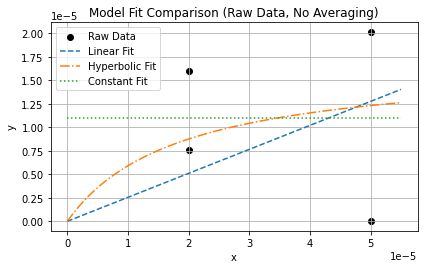

In [ ]:
# Model selector calculator

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Raw data
x_raw = np.array([0, 2e-5, 2e-5, 5e-5, 5e-5])
y_raw = np.array([0, 1.600808689906567e-05, 7.603110221147782e-06,0.0, 2.015852578745427e-05])

# 1. Omit (0, 0)
mask = ~((x_raw == 0) & (y_raw == 0))
x = x_raw[mask]
y = y_raw[mask]

# 2. Models
def linear_model(x, a):
    return a * x

def hyperbolic_model(x, a, b):
    return a * x / (b + x)

def constant_model(x, a):
    return a * np.ones_like(x)

# 3. Fit models
popt_lin, _ = curve_fit(linear_model, x, y)
p0_hyp = [np.max(y) if n_points > 0 else 1.0, np.median(x) if n_points > 0 else np.mean(x) if n_points > 0 else 1.0]
popt_hyp, _ = curve_fit(hyperbolic_model, x, y,p0=p0_hyp, bounds=([0, 0], [np.inf, np.inf]), maxfev=10000)
popt_const, _ = curve_fit(constant_model, x, y)

# 4. Predictions
y_lin = linear_model(x, *popt_lin)
y_hyp = hyperbolic_model(x, *popt_hyp)
y_const = constant_model(x, *popt_const)

# 5. Residuals and RSS
rss_lin = np.sum((y - y_lin) ** 2)
rss_hyp = np.sum((y - y_hyp) ** 2)
rss_const = np.sum((y - y_const) ** 2)

# 6. AIC and BIC
def compute_aic(n, rss, k, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + 2 * k

def compute_bic(n, rss, k, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + k * np.log(n)

n = len(y)
aic_lin = compute_aic(n, rss_lin, k=1)
bic_lin = compute_bic(n, rss_lin, k=1)
aic_hyp = compute_aic(n, rss_hyp, k=2)
bic_hyp = compute_bic(n, rss_hyp, k=2)
aic_const = compute_aic(n, rss_const, k=1)
bic_const = compute_bic(n, rss_const, k=1)

# 7. Output
print("Fitted parameters:")
print("  Linear model a =", popt_lin)
print("  Hyperbolic model a, b =", popt_hyp)
print("  Constant model a =", popt_const)
print()
print("RSS:")
print(f"  Linear:     {rss_lin:.4f}")
print(f"  Hyperbolic: {rss_hyp:.4f}")
print(f"  Constant:   {rss_const:.4f}")
print()
print("AIC:")
print(f"  Linear:     {aic_lin:.2f}")
print(f"  Hyperbolic: {aic_hyp:.2f}")
print(f"  Constant:   {aic_const:.2f}")
print()
print("BIC:")
print(f"  Linear:     {bic_lin:.2f}")
print(f"  Hyperbolic: {bic_hyp:.2f}")
print(f"  Constant:   {bic_const:.2f}")

# 8. Plot
x_plot = np.linspace(0, max(x) * 1.1, 100)
plt.scatter(x, y, color='black', label='Raw Data')
plt.plot(x_plot, linear_model(x_plot, *popt_lin), '--', label='Linear Fit')
plt.plot(x_plot, hyperbolic_model(x_plot, *popt_hyp), '-.', label='Hyperbolic Fit')
plt.plot(x_plot, constant_model(x_plot, *popt_const), ':', label='Constant Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Fit Comparison (Raw Data, No Averaging)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
